Next steps:
- profiling and optimization, parallelize
- save history data and final model
- resume next nw2vec changes + think interactions to explore them

### Imports

In [1]:
include("utils.jl")
include("layers.jl")
using .Utils
using .Layers

using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using ProgressMeter
using Statistics
using Distributions
using Random

### Define the graph and features

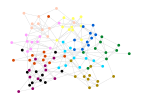

In [26]:
# Parameters
l = 10
k = 10
p_in = 0.4
p_out = 0.01
g = LightGraphs.SimpleGraphs.stochastic_block_model(
    p_in * (k - 1), p_out * k,
    k .* ones(UInt, l), seed = 6
)
communities = [c for c in 1:l for i in 1:k]
labels = Flux.onehotbatch(communities, 1:l)
multin = DiscreteUniform(5, 19)
ufeatures = similar(labels, Float64)
for i in 1:size(ufeatures, 2)
    probs = softmax(convert(Array{Float64}, labels[:, i]))
    ufeatures[:, i] = rand(Multinomial(rand(multin), probs))
end
features = scale_center(ufeatures)

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [27]:
palette

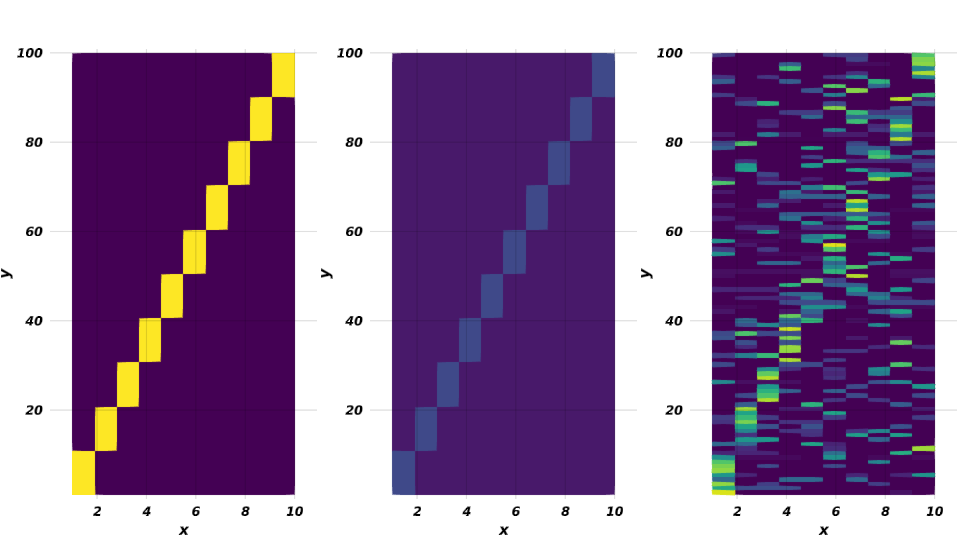

In [28]:
vbox(
    heatmap(1:l, 1:(l*k), labels),
    heatmap(1:l, 1:(l*k), softmax(convert(Array{Float64}, labels)), colorrange = (0, 1)),
    heatmap(1:l, 1:(l*k), features, colorrange = (0, 1))
)

### Plotting model state

In [29]:
adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, vae, x, refx, g, dims)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(x)
    logitÂ, unormF̂ = vae(x)
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., color = colors, markersize = markersize(embμ)),
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
    )
end

plotstate (generic function with 1 method)

In [30]:
dimξadj = 2
dimξfeat = 2
diml1 = Int64(round(sqrt(size(features, 1) * (dimξadj + dimξfeat))))
overlap = 1

# FIXME: unshare l1 once we do multitask
l1 = Layers.GC(g, l, diml1, Flux.relu, initb = Layers.nobias)
lμadj = Layers.GC(g, diml1, dimξadj, initb = Layers.nobias)
llogσadj = Layers.GC(g, diml1, dimξadj, initb = Layers.nobias)
lμfeat = Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias)
llogσfeat = Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias)


function enc(x)
    h = l1(x)
    (Layers.voverlap(lμadj(h), lμfeat(h), overlap),
        Layers.voverlap(llogσadj(h), llogσfeat(h), overlap))
end

sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)

decadj = Chain(
    Dense(dimξadj, diml1, Flux.relu, initb = Layers.nobias),
    Layers.Bilin(diml1)
)
decfeat = Chain(
    Dense(dimξfeat, diml1, Flux.relu, initb = Layers.nobias),
    Dense(diml1, l, initb = Layers.nobias),
)

vae(x) = (ξ = sampleξ(enc(x)...); (decadj(ξ[1:dimξadj, :]), decfeat(ξ[end-dimξfeat+1:end, :])))

vae (generic function with 1 method)

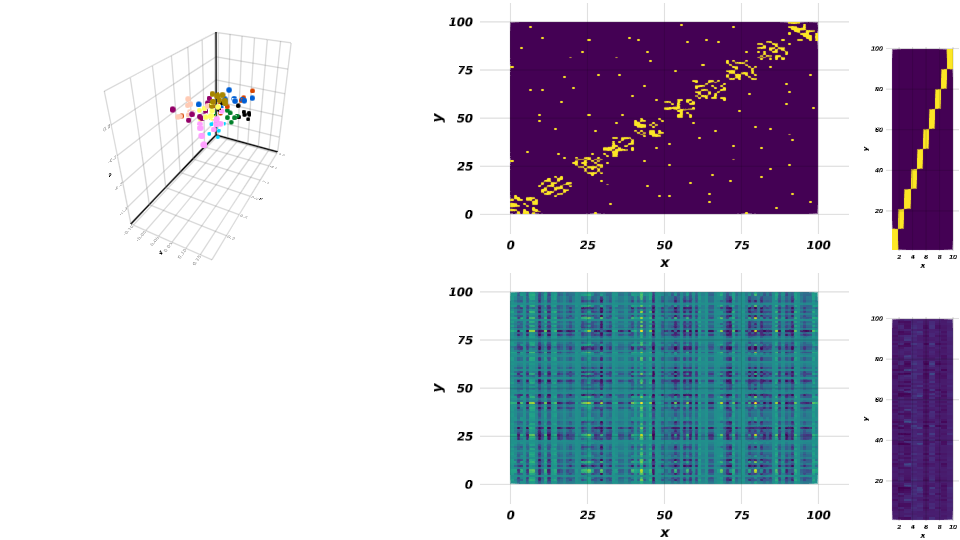

In [31]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)

In [32]:
Adiag = adjacency_matrix_diag(g)
densityA = mean(adjacency_matrix(g));

In [33]:
# Decoder regularizer
decregularizer(l = 0.01) = l * sum(x -> sum(x.^2), Flux.params(decadj, decfeat))

# Kullback-Leibler divergence
Lkl(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- 2 .* logσ)
κkl = size(g, 1) * (dimξadj - overlap + dimξfeat)

# Adjacency loss
Ladj(logitÂ) = (
    0.5 * sum(logitbinarycrossentropy.(logitÂ, Adiag, pos_weight = (1 / densityA) - 1))
    / (1 - densityA)
)
κadj = size(g, 1)^2 * log(2)

# Features loss
Lfeat(unormF̂) = - softmaxcategoricallogprob(unormF̂, labels)
κfeat = size(g, 1) * log(size(features, 1))

# Total loss
klscale = 1e-3
regscale = 1e-3
function loss(μ, logσ, logitÂ, unormF̂)
    klscale * Lkl(μ, logσ) / κkl + Ladj(logitÂ) / κadj + Lfeat(unormF̂) / κfeat + regscale * decregularizer()
end

function loss(x)
    μ, logσ = enc(x)
    ξ = sampleξ(μ, logσ)
    logitÂ, unormF̂ = decadj(ξ[1:dimξadj, :]), decfeat(ξ[end-dimξfeat+1:end, :])
    loss(μ, logσ, logitÂ, unormF̂)
end

loss (generic function with 2 methods)

In [34]:
nepochs = 1000
history_Lkl = zeros(nepochs)
history_Ladj = zeros(nepochs)
history_Lfeat = zeros(nepochs)
history_loss = zeros(nepochs)

opt = ADAM(0.01)
@showprogress for i = 1:nepochs
    Flux.train!(loss, Flux.params(l1, lμadj, llogσadj, lμfeat, llogσfeat, decadj, decfeat), zip([features]), opt)
    
    μ, logσ = enc(features)
    ξ = sampleξ(μ, logσ)
    logitÂ, unormF̂ = decadj(ξ[1:dimξadj, :]), decfeat(ξ[end-dimξfeat+1:end, :])
    
    history_Lkl[i] = Lkl(μ, logσ).data / κkl
    history_Ladj[i] = Ladj(logitÂ).data / κadj
    history_Lfeat[i] = Lfeat(unormF̂).data / κfeat
    history_loss[i] = loss(μ, logσ, logitÂ, unormF̂).data
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


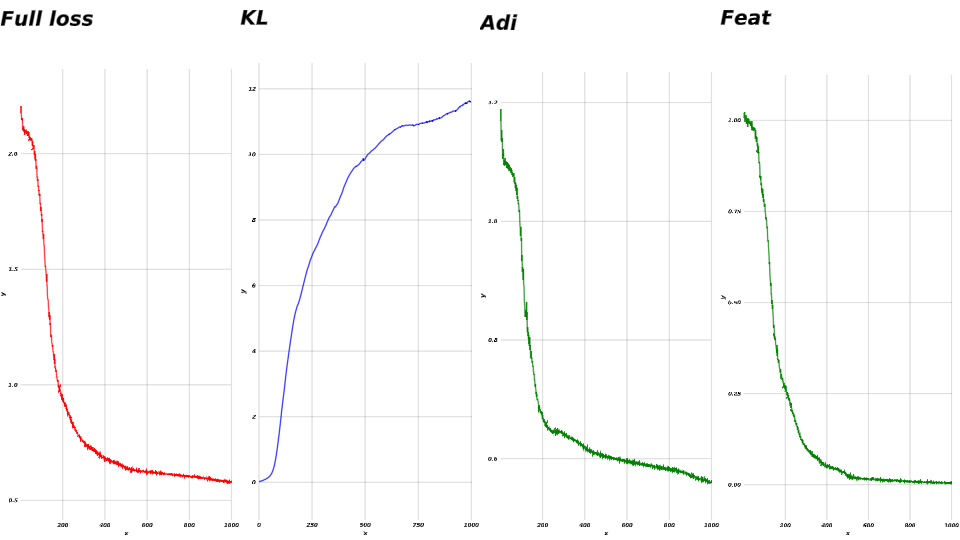

In [35]:
theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
vbox(
    hbox(lines(1:nepochs, history_loss, color = :red), text(theme, "Full loss")),
    hbox(lines(1:nepochs, history_Lkl, color = :blue), text(theme, "KL")),
    hbox(lines(1:nepochs, history_Ladj, color = :green), text(theme, "Adj")),
    hbox(lines(1:nepochs, history_Lfeat, color = :green), text(theme, "Feat"))
)

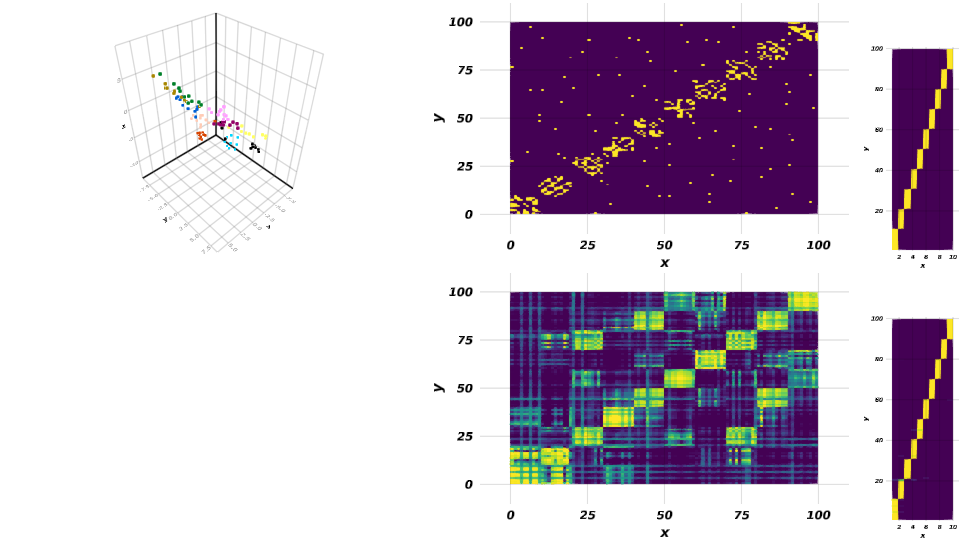

In [36]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)